# DenseNet-121
- ChestX CNN 모델과 같은 데이터셋  
(2020.11.09.) 수정

### 필요모듈호출 및 GPU 확인

In [1]:
import os
import numpy as np
import pandas as pd
from glob import glob
from itertools import chain
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, average_precision_score
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  0
2.3.1


### 경로지정 및 size 조정

In [3]:
DATA_DIR = 'C:/Users/Research/anaconda3/Visual_Pyhton3/ChestX_Classification'
# DATA_DIR2 = '../input/chest-xray-pneumonia/'
image_size = 224
batch_size = 32

### 데이터 구조 확인 및 조정

In [4]:
df = pd.read_csv(f'C:/Users/Research/anaconda3/Visual_Pyhton3/Data_Entry_2017.csv')
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,0.168,NaN
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,0.168,NaN
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,0.168,NaN
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,0.168,NaN


In [5]:
# normal_images = glob('C:/Users/Research/anaconda3/Visual_Pyhton3/ChestX_Classification/*.png')
# print(len(normal_images))

# 그리고 갑자기 glob으로 29257개만 담긴다.. 왜 그런지는 모르겠지만, 해결 방법이 안나오네
# 그래서 29257개로만 진행한다.

In [6]:
df_ = df[:29257] # 혹시모르니 data 복제(df_)

nan = []
notnan = []

sd = df_['Unnamed: 11'].astype(str) # 임의 변수 sd로 지정
print(sd)
for i in sd:
    if i == 'nan':
        nan.append(i)
    else:
        notnan.append(i)
        
print(len(nan))
print(len(notnan))

# Unnamed 11 칼럼은 모두 nan값이므로, dataframe컬럼에서 삭제

0        nan
1        nan
2        nan
3        nan
4        nan
        ... 
29252    nan
29253    nan
29254    nan
29255    nan
29256    nan
Name: Unnamed: 11, Length: 29257, dtype: object
29257
0


In [7]:
df = df[:29257]
df.pop('Unnamed: 11')
df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143
...,...,...,...,...,...,...,...,...,...,...,...
29252,00007621_009.png,Atelectasis|Effusion,9,7621,27,M,PA,2500,2048,0.168,0.168
29253,00007621_010.png,Effusion,10,7621,27,M,PA,2500,2048,0.168,0.168
29254,00007622_000.png,Edema|Effusion|Infiltration,0,7622,15,M,AP,2048,2500,0.168,0.168
29255,00007622_001.png,Effusion|Infiltration,1,7622,15,M,AP,2048,2500,0.168,0.168


In [8]:
data_image_paths = {os.path.basename(x): x for x in glob(os.path.join(DATA_DIR, 'images*', '*', '*.png'))}
df['path'] = df['Image Index'].map(data_image_paths.get)
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))

<ipython-input-8-43027e9e58bf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['path'] = df['Image Index'].map(data_image_paths.get)
<ipython-input-8-43027e9e58bf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))


In [9]:
normal_images = glob('C:/Users/Research/anaconda3/Visual_Pyhton3/ChestX_Classification/*.png')
normal_data = {'path': normal_images, 'Finding Labels': 'Normal'}
df1 = pd.DataFrame(normal_data)
df = pd.concat([df,df1], ignore_index=True, axis=1)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,None,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,None,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,None,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,0.171,None,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,None,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29252,00007621_009.png,Atelectasis|Effusion,9,7621,27,M,PA,2500,2048,0.168,0.168,None,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
29253,00007621_010.png,Effusion,10,7621,27,M,PA,2500,2048,0.168,0.168,None,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
29254,00007622_000.png,Edema|Effusion|Infiltration,0,7622,15,M,AP,2048,2500,0.168,0.168,None,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
29255,00007622_001.png,Effusion|Infiltration,1,7622,15,M,AP,2048,2500,0.168,0.168,None,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal


In [10]:
## None 값 삭제

df.pop(11)
df

,0,1,2,3,4,5,6,7,8,9,10,12,13
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,0.171,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29252,00007621_009.png,Atelectasis|Effusion,9,7621,27,M,PA,2500,2048,0.168,0.168,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
29253,00007621_010.png,Effusion,10,7621,27,M,PA,2500,2048,0.168,0.168,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
29254,00007622_000.png,Edema|Effusion|Infiltration,0,7622,15,M,AP,2048,2500,0.168,0.168,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal
29255,00007622_001.png,Effusion|Infiltration,1,7622,15,M,AP,2048,2500,0.168,0.168,C:/Users/Research/anaconda3/Visual_Pyhton3/Che...,Normal


In [11]:
# 혹시 모르니까 경로 다시 한 번 확인
df[12]

0        C:/Users/Research/anaconda3/Visual_Pyhton3/Che...
1        C:/Users/Research/anaconda3/Visual_Pyhton3/Che...
2        C:/Users/Research/anaconda3/Visual_Pyhton3/Che...
3        C:/Users/Research/anaconda3/Visual_Pyhton3/Che...
4        C:/Users/Research/anaconda3/Visual_Pyhton3/Che...
                               ...                        
29252    C:/Users/Research/anaconda3/Visual_Pyhton3/Che...
29253    C:/Users/Research/anaconda3/Visual_Pyhton3/Che...
29254    C:/Users/Research/anaconda3/Visual_Pyhton3/Che...
29255    C:/Users/Research/anaconda3/Visual_Pyhton3/Che...
29256    C:/Users/Research/anaconda3/Visual_Pyhton3/Che...
Name: 12, Length: 29257, dtype: object

### Labels 확인 / Labels가 존재하면 1, 아니면 0

In [12]:
labels = np.unique(list(chain(*df[1].map(lambda x: x.split('|')).tolist())))
labels = [x for x in labels if len(x) > 0]
labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

In [13]:
for label in labels:
    if len(label) > 1:
        df[label] = df[1].map(lambda finding: 1.0 if label in finding else 0.0)

In [14]:
df

,0,1,2,3,4,5,6,7,8,9,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29252,00007621_009.png,Atelectasis|Effusion,9,7621,27,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29253,00007621_010.png,Effusion,10,7621,27,M,PA,2500,2048,0.168,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
29254,00007622_000.png,Edema|Effusion|Infiltration,0,7622,15,M,AP,2048,2500,0.168,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
29255,00007622_001.png,Effusion|Infiltration,1,7622,15,M,AP,2048,2500,0.168,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


### 1000번 이상 빈도수 출력

In [15]:
labels = [label for label in labels if df[label].sum() > 1000]
labels

['Atelectasis',
 'Consolidation',
 'Effusion',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pneumothorax']

### flow_from_dataframe 준비 / 실행

In [16]:
train_df, valid_df = train_test_split(df, test_size=0.20, random_state=2020, stratify=df[1].map(lambda x: x[:4]))

In [27]:
valid_df

,0,1,2,3,4,5,6,7,8,9,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
22936,00006052_001.png,,1,6052,51,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21608,00005750_008.png,,8,5750,24,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22604,00005986_011.png,,11,5986,33,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24866,00006525_000.png,,0,6525,22,M,PA,2048,2500,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15953,00004231_000.png,,0,4231,26,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7767,00002042_002.png,Fibrosis,2,2042,41,F,PA,2380,2638,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17015,00004559_000.png,,0,4559,30,F,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9898,00002568_001.png,,1,2568,37,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12994,00003393_018.png,Effusion,18,3393,58,M,AP,2500,2048,0.171,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
train_df

,0,1,2,3,4,5,6,7,8,9,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
16591,00004436_007.png,Mass,7,4436,48,F,AP,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7043,00001858_000.png,,0,1858,66,F,PA,1669,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6249,00001689_009.png,,9,1689,45,M,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26674,00006985_009.png,Fibrosis,9,6985,50,M,PA,2500,2048,0.168000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19601,00005206_002.png,,2,5206,56,M,AP,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4748,00001270_004.png,Emphysema,4,1270,38,F,PA,2570,2430,0.143000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7384,00001946_029.png,Pneumothorax,29,1946,19,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
22955,00006058_000.png,,0,6058,39,M,PA,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1057,00000254_000.png,Emphysema,0,254,64,M,PA,2500,2048,0.168000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
core_idg = ImageDataGenerator(rescale=1 / 255,
                                  samplewise_center=True,
                                  samplewise_std_normalization=True,
                                  horizontal_flip=True,
                                  vertical_flip=False,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  rotation_range=10,
                                  shear_range=0.1,
                                  fill_mode='nearest',
                                  zoom_range=0.15)

train_gen = core_idg.flow_from_dataframe(dataframe=train_df,
                                             directory=None,
                                             x_col=12,
                                             y_col=1,
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

test_gen = core_idg.flow_from_dataframe(dataframe=valid_df,
                                             directory=None,
                                             x_col=12,
                                             y_col=1,
                                             class_mode='categorical',
                                             batch_size=batch_size,
                                             classes=labels,
                                             target_size=(image_size, image_size))

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df,
                                                       directory=None,
                                                       x_col=12,
                                                       y_col=1,
                                                       class_mode='categorical',
                                                       batch_size=1024,
                                                       classes=labels,
                                                       target_size=(image_size, image_size)))

Found 4964 validated image filenames belonging to 7 classes.
Found 1248 validated image filenames belonging to 7 classes.
Found 1248 validated image filenames belonging to 7 classes.


### 모델 생성(DenseNet121)
 - DenseNet121 말고 다른 모델도 사용하면 성능 차이는 얼마일까?
 - Ex. GoogleNet(Inception) / UNet 등등..
 - 이 데이터에서 가장 좋은 성능을 보이는건 DenseNet-121

In [20]:
from tensorflow.keras.applications import DenseNet121

dnet = DenseNet121(
        input_shape=(image_size, image_size, 3),
        weights='imagenet',
        include_top=False
    )

dnet.trainable = True

model = tf.keras.Sequential([
    dnet,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(len(labels), activation='sigmoid')])

model.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['AUC','Precision','Recall'])

### 세부 epochs 및 parameter 조정

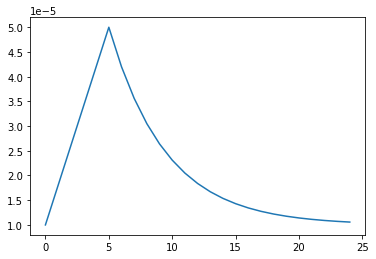

In [21]:
LR_START = 0.00001
LR_MAX = 0.00005
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

rng = [i for i in range(25)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)

In [22]:
import pydot
tf.keras.utils.plot_model(model ,show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


### Callbacks 지정 및 학습시작

In [23]:
def get_callbacks(model_name):
    callbacks = []
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f'model.{model_name}.h5',
        verbose=1,
        save_best_only=True)
    
    erly = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3) # 3번 허용. 1~2번은 너무 overfitting 가능성..
    callbacks.append(checkpoint)
    callbacks.append(erly)
    callbacks.append(lr_callback)
    return callbacks

#### 문제 : GPU Colab으로 Run
 - 용량 문제로 colab은 data_load에서 애를 먹는다(dataset:약11~12만장/43GB).
 - local에 좋은 GPU가 있었다면.. --> 해결!
 - 근데 Tesla GPU를 써도 학습 속도는 비슷하다?

In [24]:
callbacks = get_callbacks('CustomDenseNet')
history = model.fit(train_gen,
                   steps_per_epoch = 150, # 100이 적당
                   validation_data = test_gen,
                   validation_steps = 70,
                   epochs = 25,
                   callbacks = callbacks)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/25
150/150 [==============================] - ETA: 0s - loss: 0.7907 - auc: 0.4142 - precision: 0.1071 - recall: 0.3592 WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 70 batches). You may need to use the repeat() function when building your dataset.

Epoch 00001: val_loss improved from inf to 0.96180, saving model to model.CustomDenseNet.h5
150/150 [==============================] - 2447s 16s/step - loss: 0.7907 - auc: 0.4142 - precision: 0.1071 - recall: 0.3592 - val_loss: 0.9618 - val_auc: 0.4003 - val_precision: 0.1031 - val_recall: 0.3910

Epoch 00002: LearningRateScheduler reducing learning rate to 1.8000000000000004e-05.
Epoch 2/25
150/150 [==============================] - 2330s 16s/step - loss: 0.5097 - auc: 0.5611 - precision: 0.1603 - recall: 0.1201

Epoch 00003: Lea

### 마무리 / 확인

In [28]:
y_pred = model.predict(test_X)

In [29]:
for label, p_count, t_count in zip(labels,
                                     100 * np.mean(y_pred, 0),
                                     100 * np.mean(test_Y, 0)):
    print('%s: actual: %2.2f%%, predicted: %2.2f%%' % (label, t_count, p_count))

Atelectasis: actual: 18.16%, predicted: 20.62%
Consolidation: actual: 5.18%, predicted: 5.24%
Effusion: actual: 16.31%, predicted: 16.96%
Infiltration: actual: 31.54%, predicted: 28.75%
Mass: actual: 7.52%, predicted: 6.91%
Nodule: actual: 11.91%, predicted: 12.14%
Pneumothorax: actual: 9.38%, predicted: 8.80%


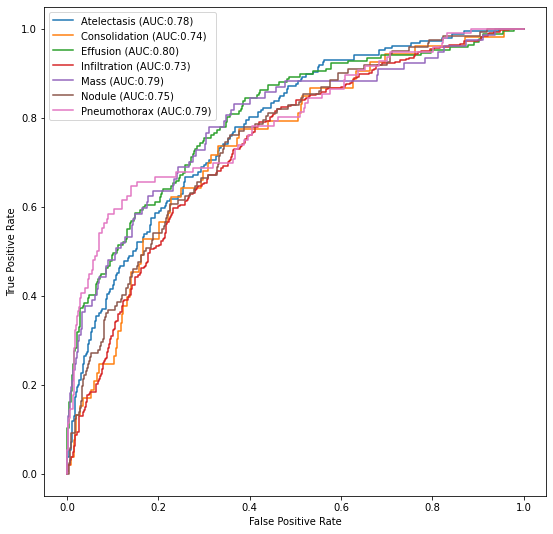

In [30]:
fig, c_ax = plt.subplots(1, 1, figsize=(9, 9))

for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:, idx].astype(int), y_pred[:, idx])
    c_ax.plot(fpr, tpr, label='%s (AUC:%0.2f)' % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

In [31]:
print('ROC auc score: {:.3f}'.format(roc_auc_score(test_Y.astype(int), y_pred)))

ROC auc score: 0.770


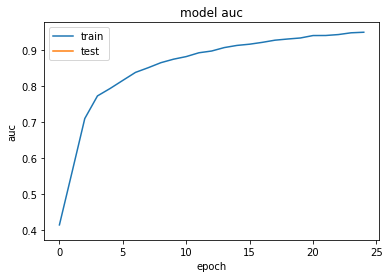

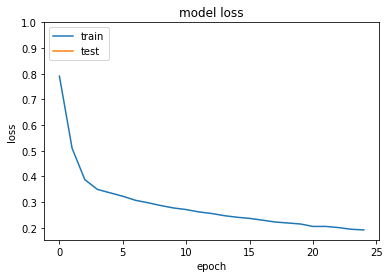

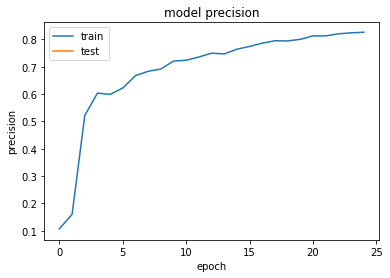

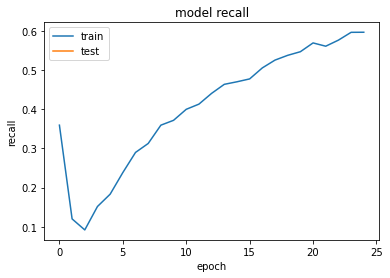

In [32]:
plt.plot(history.history['auc']) 
plt.plot(history.history['val_auc']) 
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

plt.plot(history.history['recall']) 
plt.plot(history.history['val_recall']) 
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Discussion
- DenseNet-121로 ChestX-ray8 dataset에서 1000번 이상 검출된 질환에 대해 14개 label로 추려졌으며,  
14개 중 1개의 질환이 있으면 1, 없으면 0으로 sigmoid함수를 활용 binary_crossentropy를 사용하였다(세부병명기입).  
  
- 현 과제 중, PSG 상태에서의 OSA 영상하에 수면무호흡증 진단은 총 4개의 category가 있으며,  
우선, 위 모델은 flow_from_dataframe으로 categorical 후 최종에서 sigmoid / binary_crossentropy 사용
  
(2020.11.10.) - 수정  
1. glob 데이터에 약 29500장밖에 안담아진다.. 갑자기?
2. 그래서 약 29500개의 data로 진행했고, class는 7개로 확 줄음 ㅠㅠ  
3. loss 및 curve graph 보면서 개선방향 확립요망